- title: Learning from Human Feedback
- summary: step by step tutorial about TAMER
- author: Silvia TULLI
- feedback and revision: Kim BARAKA, Mohamed CHETOUANI
- teaching assistant: Loïc GOASGUEN
- date: 2023-11-20

This notebook contains an excerpt from the **Human-Interactive Robot Learning (HIRL)** educational module.\
For more information check out [our website](https://sites.google.com/view/hirl-education?usp=sharing).


The practical can be done alone or with a colleague. Please add below your information.

Student(s):\
(1) NAME   KOBBI      SURNAME   Islem      ID  21219928   
(2) NAME   NAIT ATMAN SURNAME   Sara       ID  21116910   


# **Goals**
* Familiarize with [OpenAI Gymnasium](https://gymnasium.farama.org/) environments.
* Understand and apply Learning from Human Feedback techniques to simple tasks.
* Implement TAMER algorithm and a more advanced Learning from Human Feedback algorithm.
* Experiment with parameters such as the number of feedback and their modality to analyze their impact on performance.

# **Prerequisites**

* mathematics for machine learning: linear algebra, calculus, probability and statitics
* python programming for data science
* lecture on interactive robot learning, in particular read the chapter [Interactive Robot Learning](https://hal.science/hal-04060804/file/ACAI2021_chetouani_author-version.pdf)

To better understand the TAMER algorithm, it is necessary to take a step back and review the basics of Reinforcement Learning. A comprehensive reference on Reinforcement Learning is [Barto & Sutton (2018)](https://drive.google.com/file/d/14Ffi1SsuqoFEW87zqX3AE2oeMdQ5SGDZ/view?usp=sharing).



# **Reinforcement Learning from Human Feedback**
Reinforcement Learning from Human Feedback (RLHF) techniques include methods that combines reinforcement learning and human guidance to tap into human knowledge about the task and accelerate the learning of a machine learning model, making it more effective and efficient.These techniques find their application in diverse scenarios ranging from robotics to large language models. Instead of using a statistically pre-defined reward model (that would be very restrictive to calibrate human preferences), RLHF uses human feedback to help the model develop a more subtle reward model.


# **Training an Agent Manually via Evaluative Reinforcement**

When demonstrations are challenging for humans to provide, evaluative feedback (i.e., evaluating the quality of a certain action at a given state) can be more intuitive. The TAMER (Training an Agent Manually via Evaluative Reinforcement) algorithm combines elements of imitation learning with evaluative reinforcement learning, addressing the difficulty in providing demonstrations. The agent receives a reward signal from the environment as well as additional feedback from the human.

The key components of TAMER are:
* The **learning algorithm to predict the human feedback**, it could be a supervised learning algorithm or an RL algorithm.

* The **combination of the reward with the human feedback**, whenever the human feedback is present, TAMER combines the rewards from the environment and the human to update the Q-values. In this case, the algorithm aims to learn a policy that aligns with both the environmental reward structure and the feedback provided by the human.

* The **iterative process** where the agent interacts with the environment, receives feedback from the human, updates its policy, and repeats the process. This iterative loop allows the agent to learn from both environmental rewards and human guidance.

TAMER differs from traditional imitation learning in that it does not require a fully labeled dataset of expert demonstrations. Instead, it leverages ongoing feedback from a human during the learning process.

For the update rule you can use the SARSA algorithm and integrate the human feedback. Check out the reference **Knox, W.B., & Stone, P. (2012)** section 3.1 for further information.

# **SARSA algorithm**
![SARSA](https://drive.google.com/uc?id=19G-7Xxknc6k9Y13fOXPNb_TValLqY73F)

The core steps of the TAMER algorithm are as follows:
1. Initialize the agent's policy.
2. Interact with the environment using this policy.
3. Collect human feedback on the agent's actions.
4. Update the agent's policy using the feedback.
5. Repeat steps 2-4 until the agent's performance improves.


First, we install and import the necessary libraries.
* OpenAI Gym is an open-source platform developed by OpenAI to provide a standardized environment for testing and developing reinforcement learning algorithms.
* matplotlib and imageio are used to render the environment.

In [1]:
# !pip install gym
# !pip install matplotlib

In [1]:
# Import libraries
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import imageio
from IPython.display import display as disp
from IPython.display import clear_output

# **CartPole Environment**

The CartPole environment is a simple physics simulation where a pole is attached to a cart, and the agent's goal is to balance the pole upright by moving the cart left or right. The environment is considered solved if the agent as soon as one of the termination conditions is satisfied.

1. **Observation Space**: the state (observation) space is continuous and has four dimensions. These dimensions represent:
<ul type="square">
<li>Cart position</li>
<li>Cart velocity</li>
<li>Pole angle</li>
<li>Pole angular velocity</li>
</ul>

2. **Action Space**: the action space is discrete and consists of two possible actions:
<ul type="square">
<li>Move the cart to the left</li>
<li>Move the cart to the right</li>
</ul>
3. **Rewards**:
<ul type="square">
<li>The agent receives a positive reward for each time step the pole remains upright.</li>
<li>The episode ends when the pole tilts too far from the vertical position or the cart moves too far from the center.</li>
<li>In standard CartPole environments, there is no negative reward for taking actions. The goal is to encourage the agent to balance the pole rather than merely stopping it from falling.</li>
</ul>
4. **Termination**:
<ul type="square">
<li>An episode terminates if the pole angle is greater than a certain threshold (the angle of the pole is more than ±12 degrees from the vertical or the position of the cart is more than ±2.4 units from the center).</li>
<li>It can also terminate if the cart moves outside the specified range.</li>
</ul>


In [2]:
def disc_state(state) : 
    
    b = np.array([0 if x < 0 else 1 for x in state])

    return np.dot(b,[2**i for i in range(len(b))])

[[90.56331668 90.57329602]
 [90.54455652 90.54689738]
 [90.38440504 90.3933784 ]
 [90.53762093 90.54168786]
 [90.56414938 90.5217701 ]
 [90.4039161  90.41272636]
 [90.56178783 90.5589396 ]
 [90.58137539 90.61609691]
 [90.49892995 90.49073109]
 [90.33935992 90.35209825]
 [90.48420415 90.44199359]
 [90.41630903 90.47913539]
 [90.5233849  90.46450069]
 [90.4946703  90.3958138 ]
 [90.56076424 90.56610426]
 [90.51223062 90.54546802]]


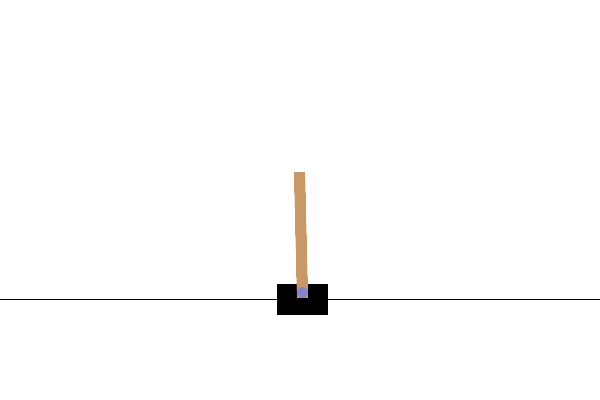

In [3]:
# Define the environment (example: CartPole)
env = gym.make("CartPole-v1",  render_mode="rgb_array")

# Define TAMER agent
class TAMERAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.q_values = np.zeros((state_size, action_size))

    def act(self, state):
        # Ensure state is an integer
        # state = int(np.squeeze(state)) if np.squeeze(state).ndim == 0 else int(np.squeeze(state)[0])

        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.q_values[state, :])

    def update_q_values_human(self, state, action, reward, human_feedback, next_state, next_action):
        # Convert states to integers
        # state = int(state[0])
        # next_state = int(next_state[0])

        B = 2

        # Update Q-values using the update rule, you can modify the SARSA update rule to integrate the human feedback
        # Add your code here
        self.q_values[state, action] = self.q_values[state,action] + alpha * (( reward + B *  human_feedback) + gamma * self.q_values[next_state, next_action] - self.q_values[state, action]) #############

# Define Hyperparameters
# Add your code here
alpha =  0.1 # Learning rate
gamma =  0.99 # Discount factor
epsilon =  0.99 # Exploration-exploitation trade-off

# Initialize TAMER agent
action_size = env.action_space.n
tamer_agent = TAMERAgent( 16, action_size)

## Training TAMER agent
num_episodes = 5000
visualization_interval = 50  # Display every 50 episodes

# Track metrics
total_rewards = []

# Track total reward per step
total_reward_per_step = []
exploration_rates = []

# Creating a dictionary to retrieve the actions' description
# Add your code here
actions_dic = {0: 'left', 1: 'right'}

# Counter for collecting human feedback
feedback_counter = 0

# Create a list to store frames for generating GIF
frames = []

# Track metrics
total_rewards = []
exploration_rates = []


for episode in range(num_episodes):
    state, _ = env.reset()
    state_enc = disc_state(state)
            
    done = False
    total_rewards = []
    
    next_action = tamer_agent.act(state=state_enc)

    while not done:
        # Agent takes an action
        # Add your code here
        action = next_action


        # Environment executes the action
        # Add your code here
        next_state, reward, done,_ , _ = env.step(action)
        next_state_enc = disc_state(next_state)
        next_action = tamer_agent.act(state=next_state_enc)

        # Print Q-values for debugging
        # Add your code here
        if episode % 100 == 0 and 0 :
            clear_output(wait=True)
            disp("epsode : ", episode)
            disp("q_values : ",tamer_agent.q_values.T)

        # Visualization during training
        if episode % visualization_interval == 0 or feedback_counter < 5:
            frames.append(env.render())
            if feedback_counter < 5:
                plt.imshow(env.render())
                plt.title(f"Episode: {episode}, State: {state}, Action: {actions_dic.get(action)}")
                plt.axis('off')
                plt.show()
                display.clear_output(wait=True)

        if feedback_counter < 5:
            # Collect human feedback (in Colab, you might use a simple input() for feedback)
            human_feedback = float(input("Provide feedback (-1, 0, 1): "))

            # Use the method defined above to update the agent based on the reward and human feedback
            # Add your code here
            
            tamer_agent.update_q_values_human(state_enc, action, reward, human_feedback, next_state_enc, next_action)
            # Increment feedback counter
            feedback_counter += 1
        else : 
            tamer_agent.update_q_values_human(state_enc, action, reward ,0, next_state_enc, next_action)

        

        # Track total rewards
        total_rewards.append(reward)

        # Track exploration rate
        exploration_rates.append(epsilon)

        # Move to the next state
        state = next_state

        # Track total reward per step
        total_reward_per_step.append(sum(total_rewards))



# Close the environment to free up resources
env.close()

# Generate and display GIF
imageio.mimsave('learning_process.gif', frames, fps=60)
print(tamer_agent.q_values)
with open('learning_process.gif','rb') as f:
    display.display(display.Image(data=f.read(), format='png'))


### **Question 1**
* To familiarize with OpenAI gym, check other OpenAI gym environments and report the information about the observation space, action space, rewards and termination.

* To have a running example with a greater amount of feedback, reproduce the results from the [original GitHub repository](https://github.com/benibienz/TAMER).

* Highlight the differences between the approach presented in this notebook and the one of the original repository (pen and paper).

### *Reponse à la question 1*

* pour  l environnement CartPole:
Espace d'observation : Continu avec quatre dimensions représentant la position du chariot, la vélocité du chariot, l'angle du poteau et la vélocité angulaire du poteau.
Espace d'action : Discret avec deux actions possibles, déplacer le chariot à gauche ou à droite.
Récompenses : Le chariot reçoit une récompense positive à chaque étape où le poteau reste debout. Aucune récompense négative n'est donnée pour les actions prises.
Terminaison : Un épisode se termine si l'angle du poteau dépasse un certain seuil ou si le chariot se déplace trop loin du centre.

* pour l'environnement mountaincar:espace d'observation : Continu avec deux variables représentant la position et la vélocité du char.
Espace d'action : Discret avec trois actions possibles, appliquer une force pour déplacer le char à gauche, ne pas appliquer de force, appliquer une force pour déplacer le char à droite.
Récompenses : Le char reçoit une récompense de -1 à chaque étape, avec pour objectif d'atteindre rapidement le drapeau. Un épisode est considéré comme résolu si le char atteint le drapeau.
Terminaison : Un épisode se termine lorsque le char atteint le drapeau ou s'il va trop loin à gauche.


* dans ce tp agent utilise une fonction d'approximation (Q-values Sarsa) pour prendre des décisions et est mis à jour à l'aide du feedback humain, alors que dans le [dépôt original](https://github.com/benibienz/TAMER) l'agent est un agent Q-learning adapté à TAMER.

# **Mountain Car Environment**
The MountainCar environment consists of an underpowered car placed between two hills (mountains) and must reach the flag located on the right hill. The challenge is that the car is not powerful enough to directly ascend the steeper hill, so it needs to learn a strategy of rocking back and forth to build enough momentum to reach the flag.
1. **Observation Space**: the state space is continuous and consists of two variables:
<ul type="square">
<li>Car position</li>
<li>Car velocity</li>
</ul>
2. **Action Space**: the action space is discrete, with three possible actions:
<ul type="square">
<li>Apply a force to move the car left</li>
<li>Apply no force</li>
<li>Apply a force to move the car right</li>
</ul>
3. **Rewards**:
<ul type="square">
<li>The agent receives a reward of $-1$ for each time step, with the goal of reaching the flag quickly.</li>
<li>An episode is considered solved if the agent reaches the flag (position >= $0.5$).</li>
<li>The episode terminates if the car position goes beyond the specified range</li>
</ul>
4. **Termination**:
<ul type="square">
<li>An episode terminates when the car reaches the flag (position >= $0.5$)</li>
<li>The episode can also terminate if the car goes too far to the left</li>
</ul>

In your **TAMERAgent** below, when the agent selects an action during training using the act method, it's choosing one of these three discrete actions based on the Q-values.

In [4]:
def discretize(state):
    discretized_state = []

    for dim_values, num_bins in zip(state, [3,3]):
        bin_edges = np.linspace(-0.5, 0.5, num_bins + 1)
        discretized_dim = np.digitize(dim_values, bin_edges) - 1
        discretized_state.append(discretized_dim)

    return tuple(discretized_state)

def encode_state(state):
    variables = discretize(state)
    encoded_state = int(np.dot(variables, [3**i for i in range(len(variables))]))

    # Ensure the result is within the desired range (0 to 10^4)
    encoded_state = max(0, min(encoded_state, 3**2 - 1))

    return encoded_state

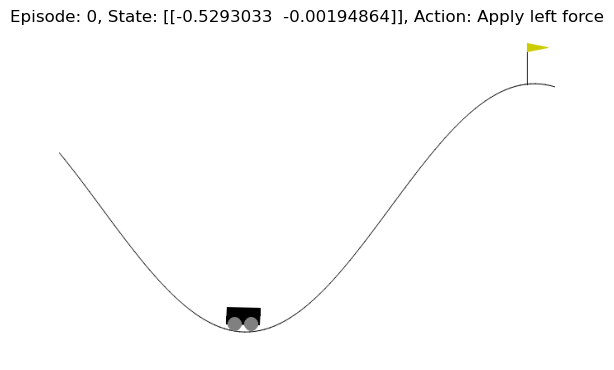

In [5]:
# Define the environment (MountainCar)
env = gym.make("MountainCar-v0", render_mode="rgb_array")


# Define TAMER agent
class TAMERAgent:
    
    def __init__(self, state_size, action_size, alpha, gamma):
        self.state_size = state_size
        self.action_size = action_size
        self.q_values = {}  # Using a dictionary for Q-values
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor

    def act(self, state):
        state_key = tuple(state.flatten())
        if state_key not in self.q_values or not self.q_values[state_key]:
            return env.action_space.sample()
        else:
            return max(self.q_values[state_key], key=self.q_values[state_key].get)

    def update_q_values(self, state, action, reward, human_feedback, next_state):
        # Convert states to tuples
        state = tuple(state.flatten())
        next_state = tuple(next_state.flatten())
        self.q_values[tuple(state), action] = self.q_values.get(tuple(state), {}).get(action, 0) + alpha * ((reward + 2 * human_feedback) + gamma * self.q_values.get(tuple(next_state), {}).get(next_action, 0) - self.q_values.get(tuple(state), {}).get(action, 0))


# Define Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1  # Exploration-exploitation trade-off

# Initialize TAMER agent
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
tamer_agent = TAMERAgent(state_size, action_size, alpha, gamma)

# Training TAMER agent
num_episodes = 1000
max_ep_steps = 100
visualization_interval = 50  # Display every 50 episodes

# Creating a dictionary to retrieve the actions' description
actions_dic = {0: 'Apply left force', 1: 'Apply no force', 2: 'Apply right force'}

# Counter for collecting human feedback
feedback_counter = 0
# Track metrics
total_rewards = []

# Track total reward per step
total_reward_per_step = []
exploration_rates = []

# Create a list to store frames for generating GIF
frames = []

# Track total rewards
total_rewards = []

# Track total reward per step
total_reward_per_step = []



for episode in range(num_episodes):
    state, _ = env.reset()
    state = state.reshape(1, state_size)

    #print(state)
    #print(state.shape)
    done = False
    episode_reward = 0  # Track the total reward for the current episode
    ep_steps = 0

    while not done and ep_steps < max_ep_steps:
        # Agent takes an action
        action = tamer_agent.act(state)
        #print("action:",action)

        # Environment executes the action
        next_state, reward, done, _, _ = env.step(action)
        
        next_state=next_state.reshape(1, state_size)
        next_action = tamer_agent.act(state=next_state)
        #print(next_state,next_state.shape)

        # Print Q-values for debugging
        # print(f"Q-values: {tamer_agent.q_values}")

        # Visualization during training
        if episode % visualization_interval == 0 or feedback_counter < 60:
            frames.append(env.render())

            if feedback_counter < 6 :
                plt.imshow(env.render())
                plt.title(f"Episode: {episode}, State: {state}, Action: {actions_dic.get(action)}")
                plt.axis('off')
                plt.show()
                display.clear_output(wait=True)

            if feedback_counter < 6 :
                # Collect human feedback using the continuous feedback function
                human_feedback = float(input("Provide feedback (-1, 0, 1): "))

                # Update the agent based on the reward and human feedback
                tamer_agent.update_q_values(state, action, reward, human_feedback, next_state)

                # Increment feedback counter
                feedback_counter += 1

        # Move to the next state
        state = next_state
        total_rewards.append(reward)
        exploration_rates.append(epsilon)

        # Track total rewards for the episode
        episode_reward += reward
        ep_steps += 1


    # Track total reward per step for the current episode
    total_reward_per_step.append(sum(total_rewards))


# Close the environment to free up resources
env.close()

# Generate and display GIF
imageio.mimsave('learning_process.gif', frames, fps=60)
with open('learning_process.gif', 'rb') as f:
    display.display(display.Image(data=f.read(), format='png'))

### **Question 2**
* Define **MDP\R** (pen and paper)
* Suggest alternative ways to integrate human feedback
* In this TP you used the keyboard, list alternative interfaces to collect the human feedback and include the pros and cons of each.

### *Reponse à la question  2*

* Le MDP est défini par des états représentés sous forme d'un tableau de dimension (1, 2). La première valeur représente la position, variant entre [-1.2, 0.6], tandis que la deuxième valeur représente la vitesse. En ce qui concerne les actions, nous disposons de trois valeurs (0, 1, 2), correspondant respectivement aux mouvements "gauche", "droite".La valeur de la récompense sera déterminée par le retour d'information humain,et nous l'avons integrer dans l algo SARSA afin de mettre a jour les valeurs Q.


* Les retours humains sont intégrés par le biais de la saisie des valeurs 1, -1 et 0 via le clavier. Nous les incorporons à l'aide de la fonction input(valeur), qui sera ajoutée à la valeur de récompense renvoyée par l'environnement. Cette valeur est ensuite multipliée par un coefficient beta égal à 3.

* les interfaces alternatives pour recueillir le retour humain: 

- Souris ou Écran Tactile: Les utilisateurs peuvent cliquer sur des zones spécifiques de l'écran pour fournir des retours.permet de bien definir la zone ou le mouvement volue

- Commandes Vocales: Les utilisateurs peuvent dicter des évaluations ou des actions, c'est facile et rapide à faire. Mais pas toujours précis, c'est-à-dire que l'agent peut mal comprendre ce que tu veux dire, et certaines commandes peuvent être compliquées à retenir.

- Électroencéphalographie (EEG): Mesure des signaux cérébraux pour capturer les réponses implicites. avec ça on peut meme capturer des reponses implicites  apartir des signaux electriques générés par l activité cérébrale,haute résolution temporelle. mais il est sensible aux mouvements decoup il ne faut une correction ou un recalibrage, a une résolution spatiale limitée.

- camera (expressions faciales): les utilisateurs montre sa reaction ou bien son retour, avec ça on capteur les mouvement et  meme l emotion a ton reel, mais la precision peut varier en fonction de la qualité de la camera.

### **Question 3**


* What are three fundamental differences between the reward function and the human feedback function? (pen and paper)
* Specify what is the difference in the learning update rule (pen and paper)



### *Reponse a la question3*

 les différences entre la fonction de recompense et la fonction de feedback:

- La fonction de récompense est  définie par l'environnement selon une MDP, tandis que le feedback humain est subjectif et basé sur l'expérience individuelle cest a  lindividue devaluer.
- La fonction de récompense est souvent basée sur des critères objectifs, tandis que le feedback humain peut inclure des facteurs émotionnels et sociaux.
- La fonction de récompense est globale et s'applique à toutes les situations, tandis que le feedback humain peut être spécifique à des états ou des actions.

La règle de mise à jour pour la récompense intègre généralement la récompense immédiate et les récompenses futures prévues.
La règle de mise à jour pour le feedback humain intègre l'évaluation subjective humaine dans le processus d'apprentissage.
La combinaison de la récompense et du feedback humain peut nécessiter des poids spécifiques pour équilibrer l'influence des deux sources de retour.

We offered a dummy example to illustrate how the algorithm works. However, a greater amount of human feedback is needed to train your agent. As mentioned in question 1, we recommend reproducing the code from the [original GitHub repository](https://github.com/benibienz/TAMER) on your machine and add your results in this notebook.

# **Open-ended Project**
Compare the performance of TAMER with alternative TAMER algorithm of your choice (examples of other approaches can be found in [Knox's website](https://www.bradknox.net/human-reward/)). Test it on at least two environments and come out with three relevant evaluation metrics.
* Do a benchmark of similar existing projects/approaches.
* Together with the alternative algorithm of your choice, provide details about how the algorithm works.
* Discuss your results and highlighting the advantages and limitations of your approach.
* `[optional]` Consider adding credit assignment, check section **Knox, W.B., & Stone, P. (2009)** section 3.3 for more on this.


# **References**
* Knox, W.B., & Stone, P. (2012). Reinforcement learning from simultaneous human and MDP reward. Adaptive Agents and Multi-Agent Systems. [pdf](https://www.cs.cmu.edu/~jeanoh/16-785/papers/knox-aamas2012-tamer.pdf)
* Warnell, G., Waytowich, N.R., Lawhern, V.J., & Stone, P. (2017). Deep TAMER: Interactive Agent Shaping in High-Dimensional State Spaces. ArXiv, abs/1709.10163.[pdf](https://arxiv.org/pdf/1709.10163.pdf)
* Arakawa, R., Kobayashi, S., Unno, Y., Tsuboi, Y., & Maeda, S. (2018). DQN-TAMER: Human-in-the-Loop Reinforcement Learning with Intractable Feedback. ArXiv, abs/1810.11748. [pdf](https://www.semanticscholar.org/reader/31ed72a18ed8a1008786130af9f1d61761cff4f3)
* Karalus, J., & Lindner, F. (2021). Accelerating the Learning of TAMER with Counterfactual Explanations. 2022 IEEE International Conference on Development and Learning (ICDL), 362-368. [pdf](https://www.semanticscholar.org/reader/243abd03e6fa267219d5afd82f387dddc0db26a3)
* Knox, W.B., & Stone, P. (2009). Interactively shaping agents via human reinforcement: the TAMER framework. International Conference on Knowledge Capture. [pdf](https://www.cs.utah.edu/~dsbrown/readings/tamer.pdf)
